# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm import SimulationConfig, LoopbackInterface
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qm import SimulationConfig
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm import generate_qua_script
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
res_index = 0 # for UA Q1
flux_index = 0 # for UA Q1
TLS_index = 0 # for TLS of interest

2023-11-07 09:59:23,473 - qm - INFO     - Starting session: e3dffd8e-84d6-4b98-8332-04aefa26fbcb


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine._save("quam_state.json")

# machine.qubits[0].lo = machine.qubits[0].f_01 + 150e6
# machine = Analysis.set_machine(machine)

In [4]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2023-11-06 10:16:25,223 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58


INFO:qm:Octave "octave1" Health check passed, current temperature 58


2023-11-06 10:16:25,228 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-06 10:16:25,245 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [9]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2023-11-06 11:33:08,851 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-06 11:33:08,859 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-06 11:33:16,205 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.473 GHz, -50.000 MHz)
2023-11-06 11:33:27,791 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## resonator switch calibration

### switch delay

In [ ]:
# reduce the resonator freq, so sig is stronger
machine.resonators[res_index].f_readout -= 2E6
machine._save("quam_state.json")

In [ ]:
%matplotlib inline
rr_switch_delay_sweep = np.arange(70,110,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_delay(rr_switch_delay_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

### switch buffer

In [ ]:
%matplotlib inline
rr_switch_buffer_sweep = np.arange(0,25 + 1,1)
machine, rr_switch_delay_sweep, sig_amp = Experiment.exp1D.RR.rr_switch_buffer(rr_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                          n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## Time of flight

In [ ]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 1E3, tPath = None, f_str_datetime = None, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [ ]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += -0.000341
machine.global_parameters.con1_downconversion_offset_Q += -0.000633
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [4]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                            n_avg = 1E3, cd_time = 5E3, readout_state = None, simulate_flag = False, simulation_len = 1000)
# Readout in excited state
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.04s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.13s


resonator frequency: 7260.663 MHz
Execution stopped by user!


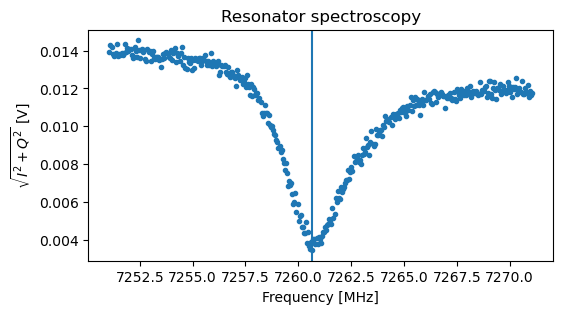

In [5]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

In [21]:
machine.resonators[res_index].f_readout

7262863478.0

## 2D RO resonator spectroscopy vs DC flux

In [ ]:
res_freq_sweep = np.arange(7.254E9,7.267E9 + 1.0,0.2E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 1E3, cd_time = 10E3)

In [4]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

NameError: name 'res_freq_sweep' is not defined

In [ ]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [ ]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [4]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.65s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.70s
resonator frequency: 7262.913 MHz


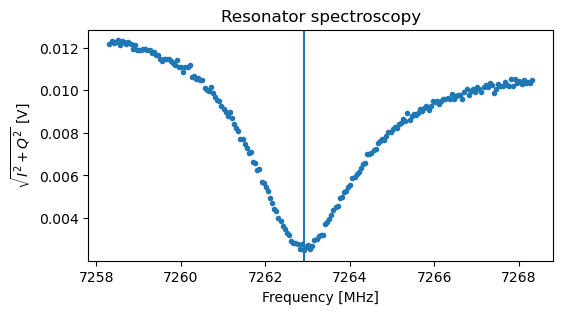

In [13]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [8]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2023-11-06 10:17:55,205 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-06 10:17:55,215 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-06 10:18:01,543 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (5.968 GHz, 453.907 MHz)
2023-11-06 10:18:14,041 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [14]:
#qubit_freq_sweep = np.arange(6.30E9,6.60E9+1,1E6)
# for the DC flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
qubit_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,0.0) * 1E6 # in Hz
# machine.qubits[qubit_index].lo = int(qubit_freq_est.tolist()) - 100E6
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-50E6, 50E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.13s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.17s


resonant frequency: 6421.663 MHz


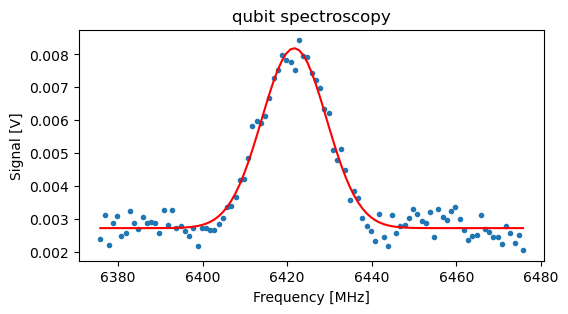

In [15]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
# machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

In [16]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2023-11-07 09:24:25,291 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-07 09:24:25,301 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-07 09:24:31,756 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.473 GHz, -51.464 MHz)
2023-11-07 09:24:44,451 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [17]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 20E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.55s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.60s


rabi_pi_pulse: 39.7 ns
half period: 39.74 ns


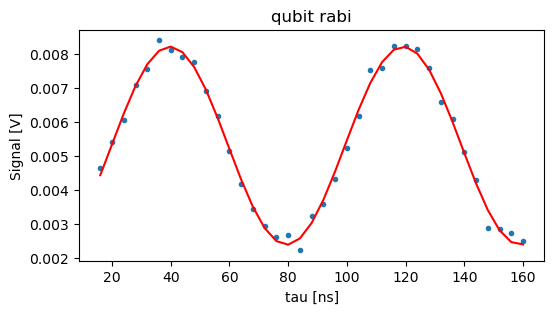

In [18]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [12]:
machine.qubits[qubit_index].pi_length[0] = 40
machine = Analysis.set_machine(machine)

### power rabi

In [19]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 22.09s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 22.14s


rabi_pi_pulse_amp: 0.05083 V
half period: 0.0507450 V


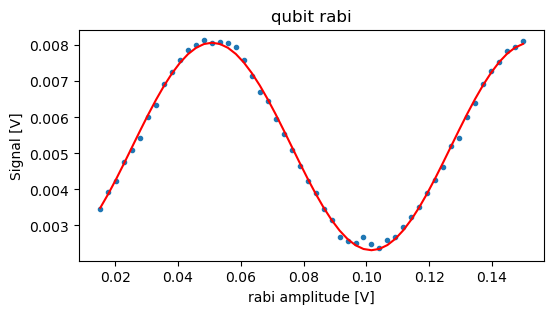

In [20]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [21]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.tolist()
machine = Analysis.set_machine(machine)

## calibrate qubit XY line switch

### switch delay

In [8]:
%matplotlib inline
qubit_switch_delay_sweep = np.arange(70,110,1)
for i in range(4):
    machine, qubit_switch_delay_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_delay(qubit_switch_delay_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 160E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = False)

Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.91s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.26s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.20s
Progress: [##################################################] 100.0% (n=40/40) --> elapsed time: 206.12s


### switch buffer

Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.07s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.37s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 73.42s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 76.03s
Progress: [##################################################] 100.0% (n=36/36) --> elapsed time: 75.50s


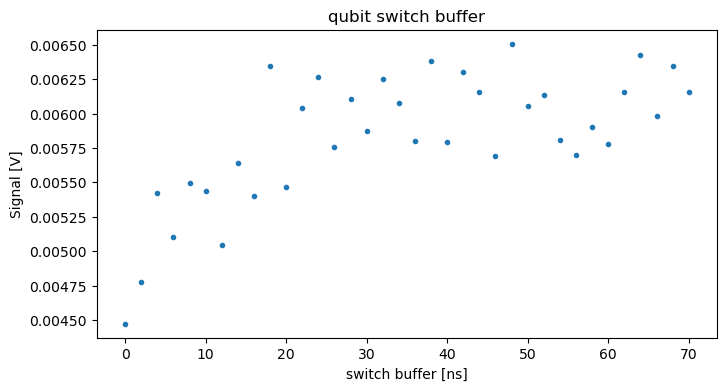

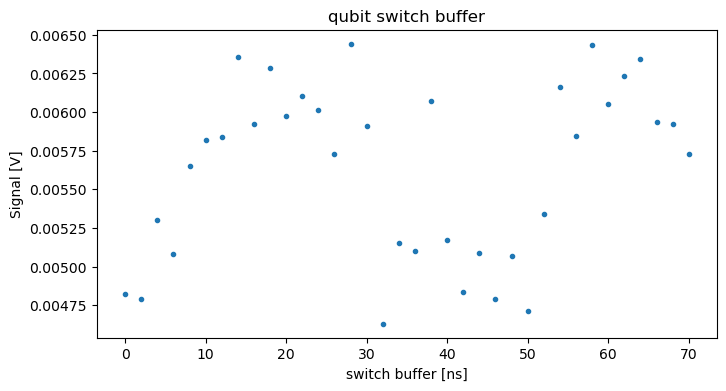

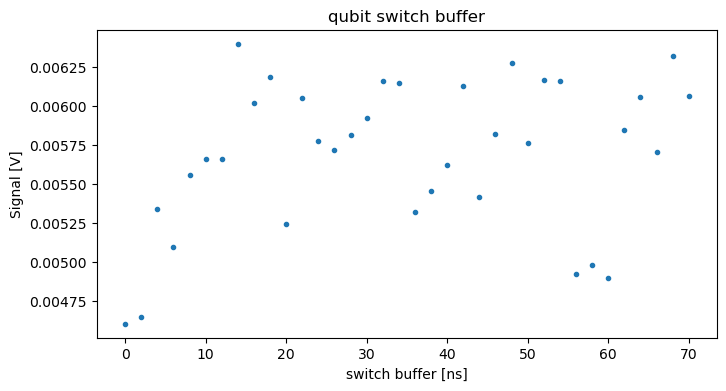

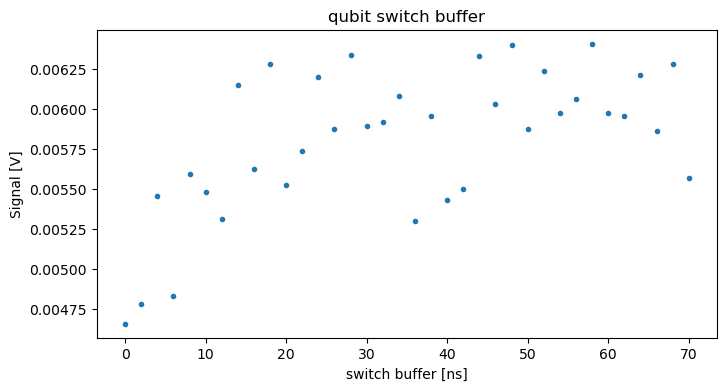

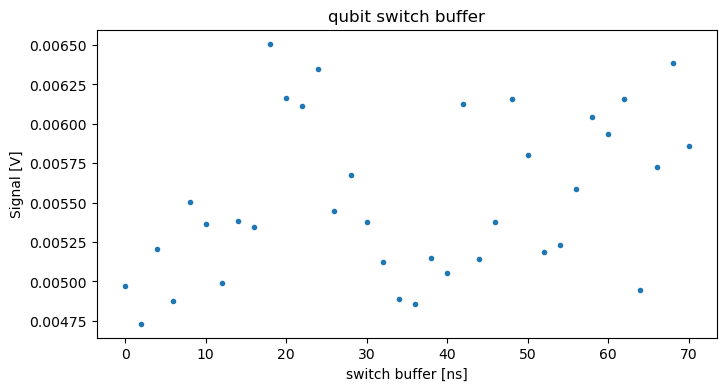

In [7]:
%matplotlib inline
qubit_switch_buffer_sweep = np.arange(0,70 + 1,2)
for k in range(5):
    machine, qubit_switch_buffer_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_switch_buffer(qubit_switch_buffer_sweep, qubit_index, res_index, flux_index, 
                              n_avg = 20E3, cd_time = 20E3, simulate_flag = False, simulation_len = 500, plot_flag = True)

## T1

In [ ]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,400)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 80E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

In [ ]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q1_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

## ef transition

### ef frequency

In [12]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.14s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.18s


resonant frequency: 6247.000 MHz


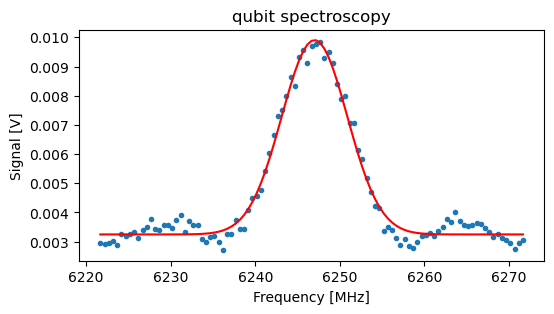

In [14]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [28]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [15]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.30s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.35s


rabi_pi_pulse: 79.8 ns
half period: 79.67 ns


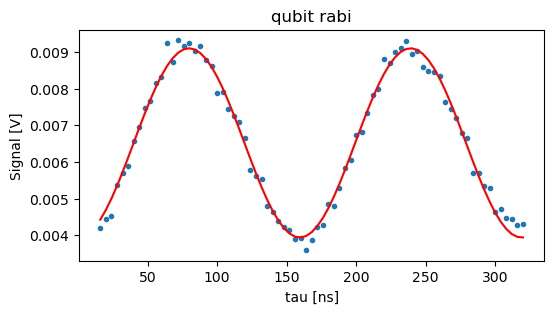

In [16]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [9]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [17]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11.57s
Execution stopped by user!


rabi_pi_pulse_amp: 0.02139 V
half period: 0.0214070 V


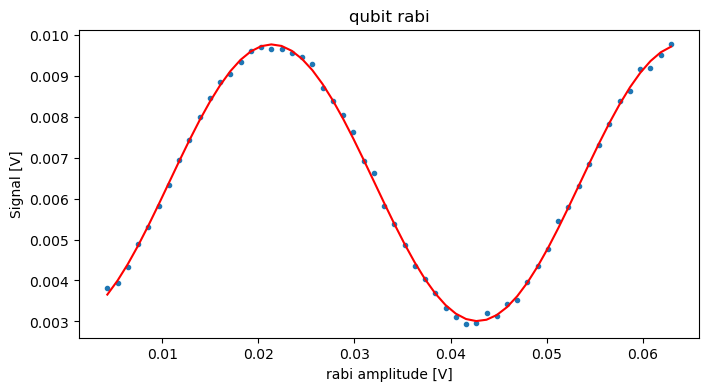

In [18]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [19]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## residual |e> state population

### |e> readout calibration

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 41.81s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 41.84s
resonator frequency: 7260.663 MHz


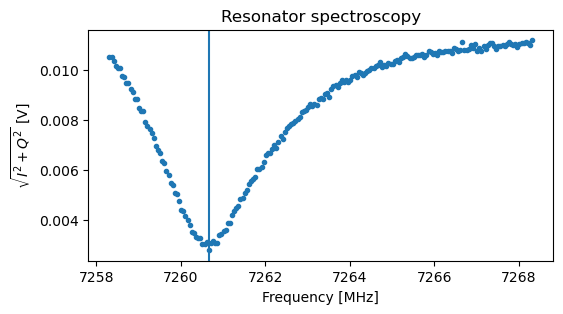

In [37]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([flux_index,machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 10E3, cd_time = 20E3, plot_flag = False, readout_state = 'e', simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [27]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2023-11-07 10:09:30,255 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-07 10:09:30,268 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.311 GHz, -50.000 MHz)
2023-11-07 10:09:36,844 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.472 GHz, -50.000 MHz)
2023-11-07 10:09:48,233 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### A_ref

In [43]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000000/10000000.0) --> elapsed time: 418.52s
Progress: [##################################################] 100.0% (n=10000000/10000000.0) --> elapsed time: 418.56s


### A_sig

In [45]:
%matplotlib qt
#rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = np.array([80/4, 160/4])  
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep_thermal, sig_amp_thermal = Experiment.exp1D.Rabi.ef_rabi_length_thermal(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 0.0,  n_avg = 1E7, cd_time = 20E3, readout_state = 'e', plot_flag = False, machine = machine, 
          simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=10000000/10000000.0) --> elapsed time: 417.79s
Progress: [##################################################] 100.0% (n=10000000/10000000.0) --> elapsed time: 417.83s


## 2D qubit spectroscopy vs dc flux

In [ ]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.6,0.6+1E-4,0.05)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 10E3, pi_amp_rel = 1.0, plot_flag = True)

In [ ]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

In [ ]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [ ]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [3]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2023-11-02 16:26:53,613 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58


INFO:qm:Octave "octave1" Health check passed, current temperature 58


2023-11-02 16:26:53,618 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-02 16:26:53,635 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [4]:
# try the experiment
%matplotlib qt
ff_sweep = np.arange(-0.02,-0.3-1E-4,-0.02)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2023-11-02 16:27:33,939 - qm - INFO     - Performing health check.0% (n=6/15) --> elapsed time: 23.33s


INFO:qm.api.frontend_api:Performing health check


2023-11-02 16:27:33,950 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.050 MHz)
2023-11-02 16:27:40,505 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.039 GHz, 290.000 MHz)
2023-11-02 16:27:52,018 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2023-11-02 16:28:27,808 - qm - INFO     - Performing health check.3% (n=11/15) --> elapsed time: 77.16s


INFO:qm.api.frontend_api:Performing health check


2023-11-02 16:28:27,823 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.050 MHz)
2023-11-02 16:28:34,665 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (5.804 GHz, 290.000 MHz)
2023-11-02 16:28:46,931 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2023-11-02 16:29:12,723 - qm - INFO     - Performing health check.3% (n=14/15) --> elapsed time: 122.09s


INFO:qm.api.frontend_api:Performing health check


2023-11-02 16:29:12,734 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.050 MHz)
2023-11-02 16:29:19,731 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (5.591 GHz, 290.000 MHz)
2023-11-02 16:29:31,501 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=15/15) --> elapsed time: 157.83s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [24]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].tuning_curve, 0.0) * 1E6)
#ff_sweep_abs = np.arange(0.0,0.3+1E-4,0.05)
#qubit_freq_sweep = np.arange(q_freq_max, 6.2E9, -4E6)
qubit_freq_sweep = np.arange(4.8E9,4.5E9,-4E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

-------------------------------------some fast flux > 0.5V, removed from experiment run
2023-11-01 14:14:15,476 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:14:15,486 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-01 14:14:22,503 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (4.500 GHz, 200.000 MHz)
2023-11-01 14:14:35,272 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 253.92s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 254.07s
2023-11-01 14:19:04,697 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-01 14:19:04,711 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2023-11-01 14:19:11,884 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (4.300 GHz, 200.000 MHz)
2023-11-01 14:19:23,295 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 75.96s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 76.13s
Execution stopped by user!
Execution stopped by user!


In [ ]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

### coarse, no baking

In [9]:
%matplotlib qt
tau_sweep_abs = np.arange(16,200,4)
ff_sweep_abs = np.arange(0.185,0.225,0.001)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 39.65s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 39.80s
Execution stopped by user!


### fine, with baking

In [10]:
%matplotlib qt
tau_sweep_abs = np.arange(4,180,2)
ff_sweep_abs = np.arange(0.185,0.22,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 536.55s
Execution stopped by user!


In [ ]:
machine.flux_lines[flux_index].iswap.length.append(30)
machine.flux_lines[flux_index].iswap.level.append(0.314)
machine = Analysis.set_machine(machine)

## TLS T1

In [6]:
%matplotlib qt
tau_sweep_abs = np.arange(200,40E3+1,1E3)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 5E3, cd_time = 100E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 23.98s
Execution stopped by user!


Qubit T1 [us]: 6.350495675897429


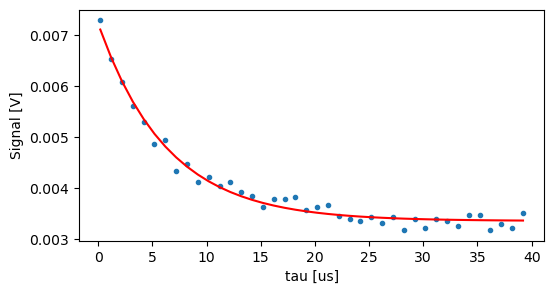

In [8]:
%matplotlib inline
q1_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [3]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].tuning_curve,machine.flux_lines[flux_index].iswap.level)
TLS_freq_est = np.round(TLS_freq_est[0] * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [4]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [9]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2023-11-03 17:04:43,984 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-11-03 17:04:43,991 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.050 MHz)
2023-11-03 17:04:50,403 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (5.968 GHz, 200.000 MHz)
2023-11-03 17:05:02,925 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [5]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 11.43s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 11.52s
Execution stopped by user!


resonant frequency: 6167.842 MHz


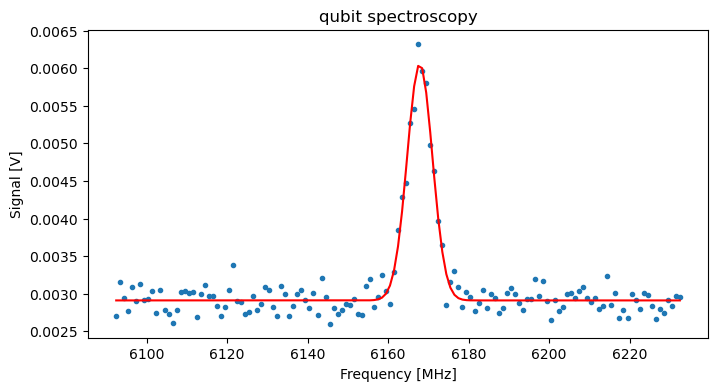

In [6]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [7]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [13]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.69s
Execution stopped by user!


## TLS drive debug

### 1D SWAP

In [8]:
%matplotlib qt
tau_sweep_abs = np.arange(16,300,4)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.SWAP.swap_coarse(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index, 
                n_avg = 4E3, cd_time = 20E3, simulate_flag=False, simulation_len=1000, plot_flag=True, machine = machine)

UnboundLocalError: local variable 'sig_amp' referenced before assignment

### qubit Rabi-SWAP

In [16]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 6.31s
Execution stopped by user!


### SWAP-Rabi

In [3]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.SWAP_rabi(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 20E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 6.08s
Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 6.21s
Execution stopped by user!


### Rabi-SWAP-SWAP

In [7]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 2)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.SWAP.rabi_SWAP2(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,  
          pi_amp_rel = 1.0, n_avg = 4E3, cd_time = 10E3, plot_flag = True, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 3.14s
Execution stopped by user!
